# 그레디언트 소멸 문제

일반적으로 레이어의 수가 많을수록 복잡한 형태의 베이시스 함수를 만들 수 있다. 하지만 레이어 수가 증가하면 가중치가 잘 수렴하지 않는 현상이 발생한다. 원인을 알아보기 위해 학습 중에 가중치가 어떻게 변화하는지를 알아보자. 

여기에서는 MNIST Digit Image 데이터를 사용한다. 여기에서는 교차검증은 하지 않을 것이므로 학습용 데이터만 사용한다.

In [1]:
from keras.datasets import mnist
from keras.utils import np_utils

(X_train0, y_train0), (X_test0, y_test0) = mnist.load_data()

X_train = X_train0.reshape(60000, 784).astype('float32') / 255.0
Y_train = np_utils.to_categorical(y_train0, 10)

Using TensorFlow backend.


비교를 위해 4개의 신경망 모형을 keras로 만든다. 모형1은 하나의 히든레이어를 가지는 모형이다. 모형2, 모형3, 모형4는 각각 2개, 3개, 4개의 히든레이어를 가진다.

In [2]:
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import SGD

model1 = Sequential()
model1.add(Dense(15, input_dim=784, activation="sigmoid"))
model1.add(Dense(10, activation="sigmoid"))
model1.compile(optimizer=SGD(lr=0.2),
               loss='mean_squared_error', metrics=["accuracy"])

model2 = Sequential()
model2.add(Dense(15, input_dim=784, activation="sigmoid"))
model2.add(Dense(15, activation="sigmoid"))
model2.add(Dense(10, activation="sigmoid"))
model2.compile(optimizer=SGD(lr=0.2),
               loss='mean_squared_error', metrics=["accuracy"])

model3 = Sequential()
model3.add(Dense(15, input_dim=784, activation="sigmoid"))
model3.add(Dense(15, activation="sigmoid"))
model3.add(Dense(15, activation="sigmoid"))
model3.add(Dense(10, activation="sigmoid"))
model3.compile(optimizer=SGD(lr=0.2),
               loss='mean_squared_error', metrics=["accuracy"])

model4 = Sequential()
model4.add(Dense(15, input_dim=784, activation="sigmoid"))
model4.add(Dense(15, activation="sigmoid"))
model4.add(Dense(15, activation="sigmoid"))
model4.add(Dense(15, activation="sigmoid"))
model4.add(Dense(10, activation="sigmoid"))
model4.compile(optimizer=SGD(lr=0.2),
               loss='mean_squared_error', metrics=["accuracy"])

이 실험에서는 학습중에 가중치가 얼마나 빠르게 변하는지를 보기 위해 가중치 변화의 (절대값의) 평균값을 한 세대(epoch)마다 기록할 것이다. 이를 위해 keras의  `Callback` 클래스를 사용한다. `Callback` 클래스는 하나의 세대가 끝날 때마다 `on_epoch_end`라는 메서드를 호출하게 된다. 이 메서드에서 각 히든레이어의 가중치 변화의 평균을 기록한다.

In [3]:
from keras.callbacks import Callback

class WeightHistory(Callback):

    def __init__(self, model, num_epoch):
        super().__init__()
        self.model = model
        self.num_hidden = len(model.layers) - 1
        self.weight_old = [
            self.model.layers[i].get_weights()[0] for i in range(self.num_hidden)]
        self.weight = [0.0 for i in range(self.num_hidden)]
        self.weight_change = np.zeros((self.num_hidden, num_epoch))

    def on_epoch_end(self, epoch, logs={}):
        for i in range(self.num_hidden):
            self.weight[i] = self.model.layers[i].get_weights()[0]
            self.weight_change[i, epoch] = \
                np.abs((self.weight[i] - self.weight_old[i])).mean()
            self.weight_old[i] = self.weight[i]

학습은 200세대만 실시하고 배치크기는 100개로 한다. 학습 진행도를 실시간으로 살펴보려면 keras_tqdm 패키지의 `TQDMCallback` 콜백 클래스를 추가하면 된다.

In [4]:
%%time
num_epoch = 200
callback1 = WeightHistory(model1, num_epoch)
hist1 = model1.fit(X_train, Y_train, epochs=num_epoch, batch_size=100, 
                   callbacks=[callback1], verbose=0)

CPU times: user 9min 6s, sys: 45 s, total: 9min 51s
Wall time: 3min 50s


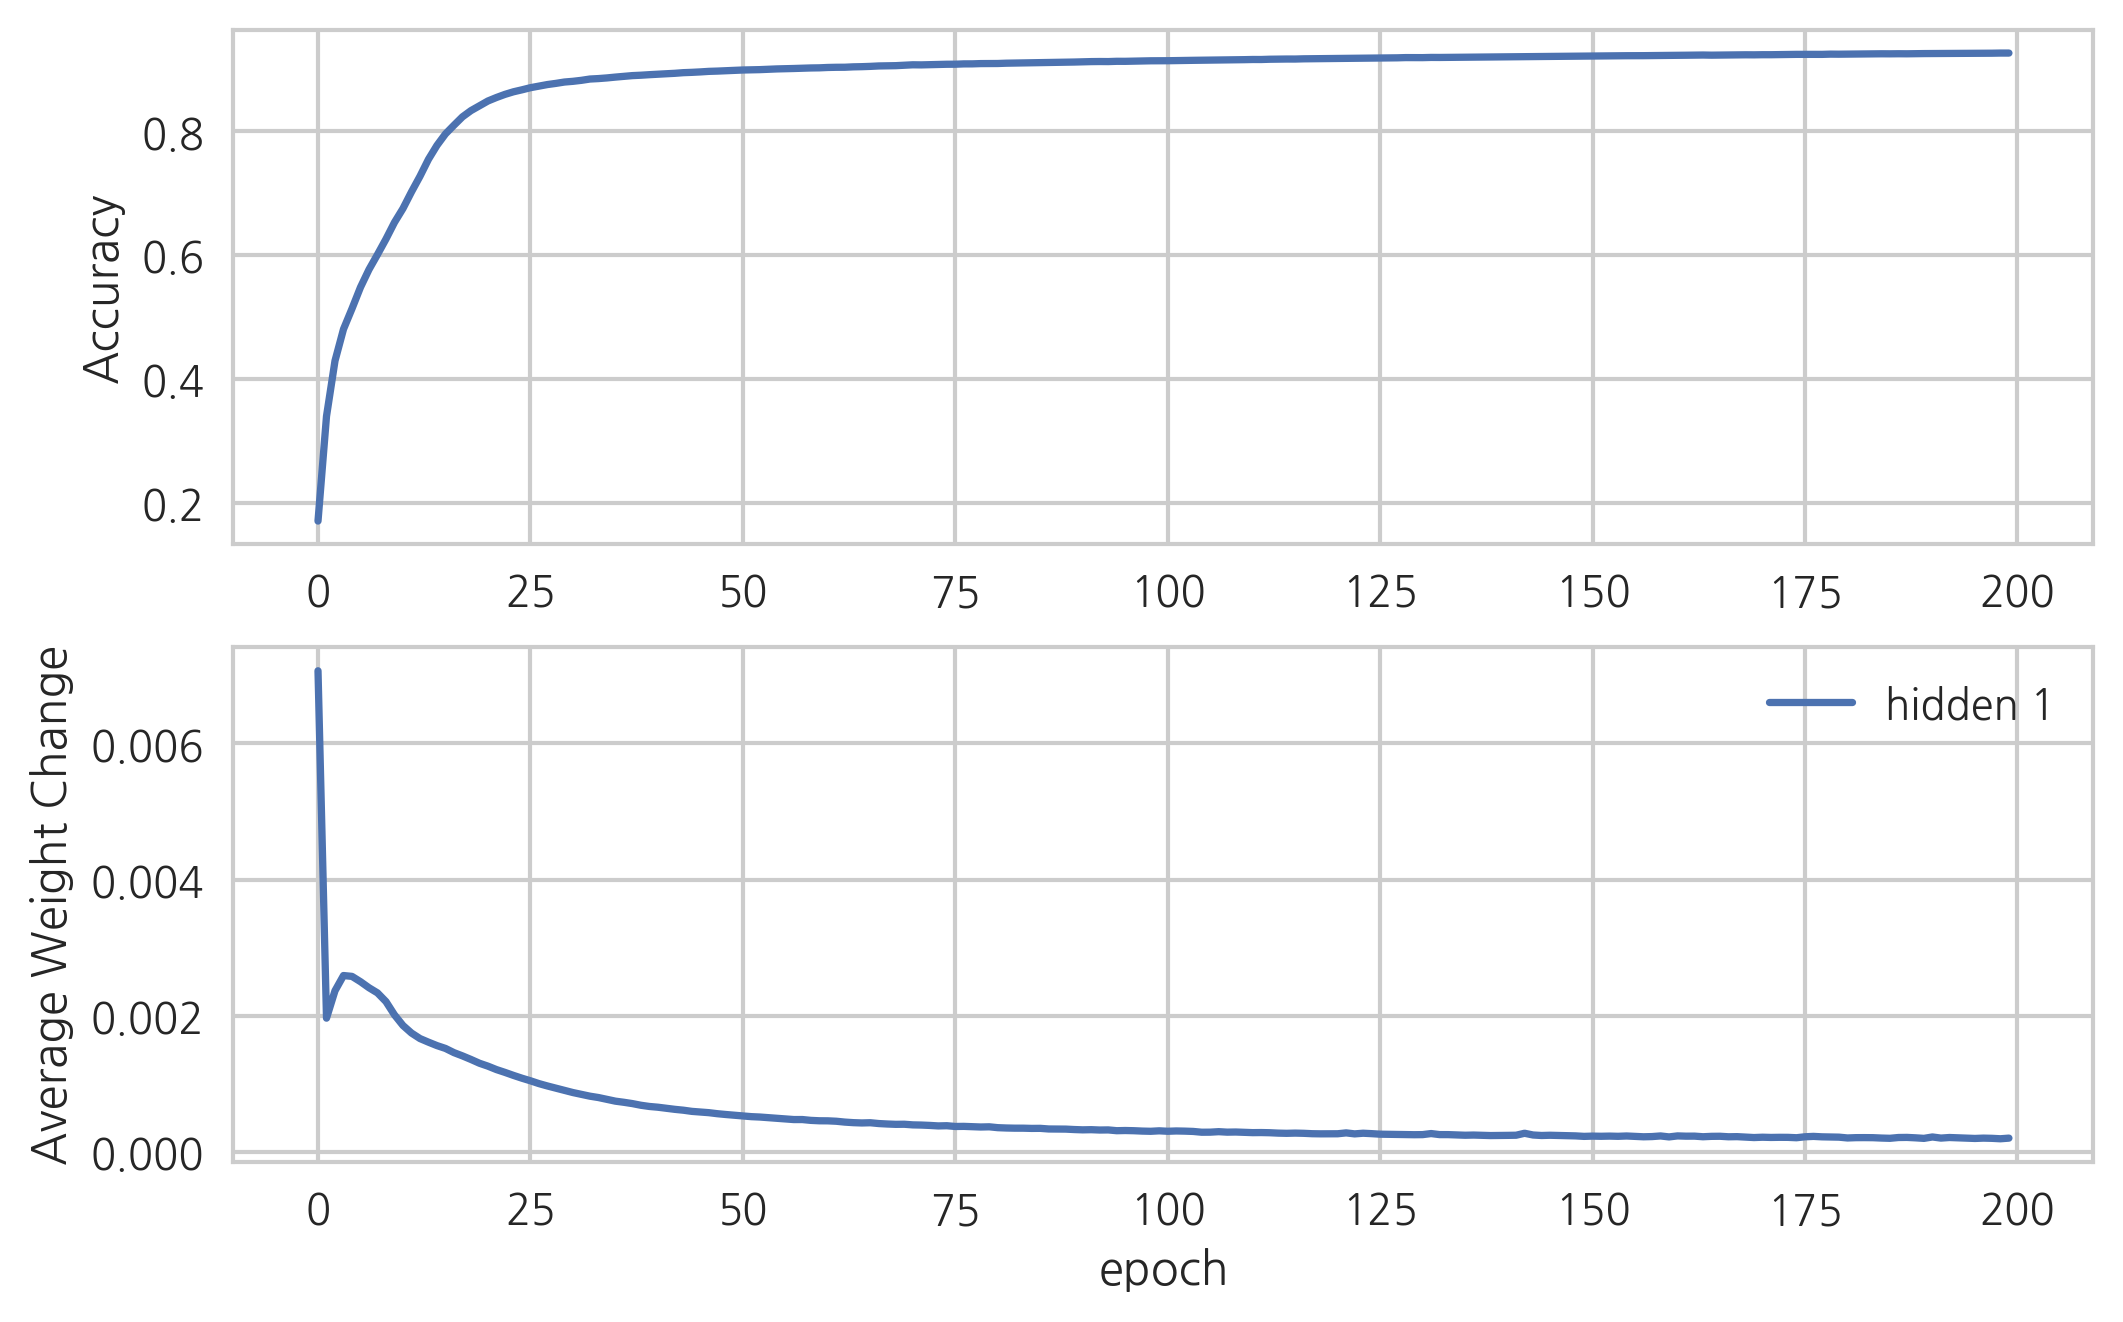

In [5]:
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(hist1.history['acc'])
plt.ylabel("Accuracy")
plt.subplot(2, 1, 2)
plt.plot(callback1.weight_change[0], label="hidden 1")
plt.xlabel("epoch")
plt.ylabel("Average Weight Change")
plt.legend()
plt.show()

In [6]:
hist1.history['acc'][-1]

0.9267333344618479

In [7]:
%%time
num_epoch = 200
callback2 = WeightHistory(model2, num_epoch)
hist2 = model2.fit(X_train, Y_train, epochs=num_epoch, batch_size=100, 
                   callbacks=[callback2], verbose=0)

CPU times: user 9min 21s, sys: 43.1 s, total: 10min 4s
Wall time: 4min 2s


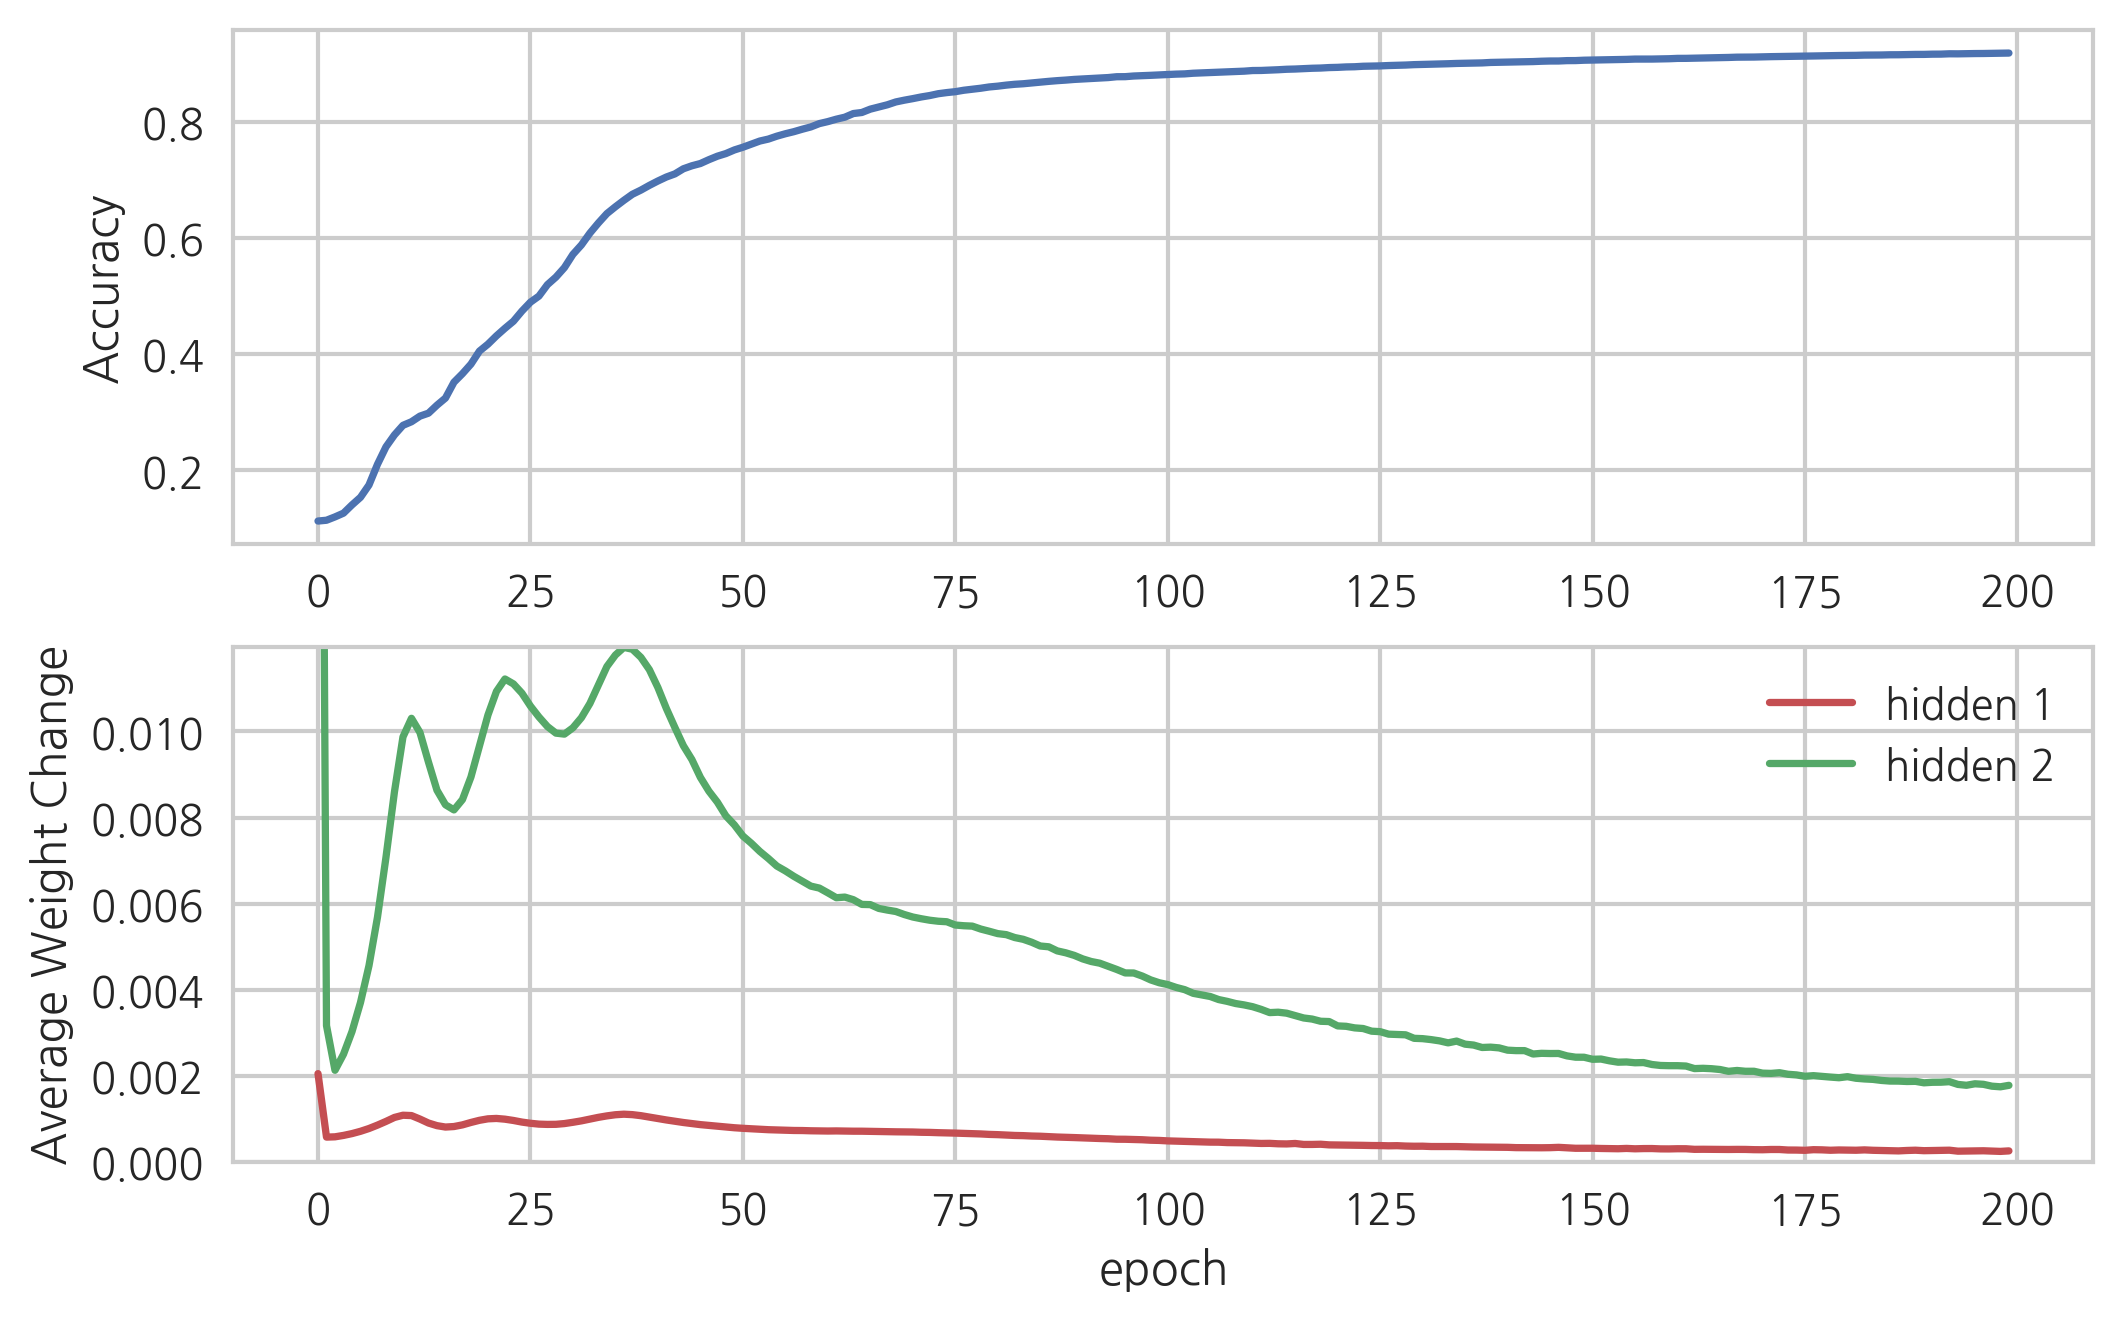

In [8]:
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(hist2.history['acc'])
plt.ylabel("Accuracy")
plt.subplot(2, 1, 2)
plt.plot(callback2.weight_change[0], 'r', label="hidden 1")
plt.plot(callback2.weight_change[1], 'g', label="hidden 2")
plt.xlabel("epoch")
plt.ylabel("Average Weight Change")
plt.ylim(0, np.max(callback2.weight_change[-1][5:]))
plt.legend()
plt.show()

In [9]:
hist2.history['acc'][-1]

0.9181000016132991

In [10]:
%%time
num_epoch = 200
callback3 = WeightHistory(model3, num_epoch)
hist3 = model3.fit(X_train, Y_train, epochs=num_epoch, batch_size=100, 
                   callbacks=[callback3], verbose=0)

CPU times: user 9min 38s, sys: 39.1 s, total: 10min 18s
Wall time: 4min 17s


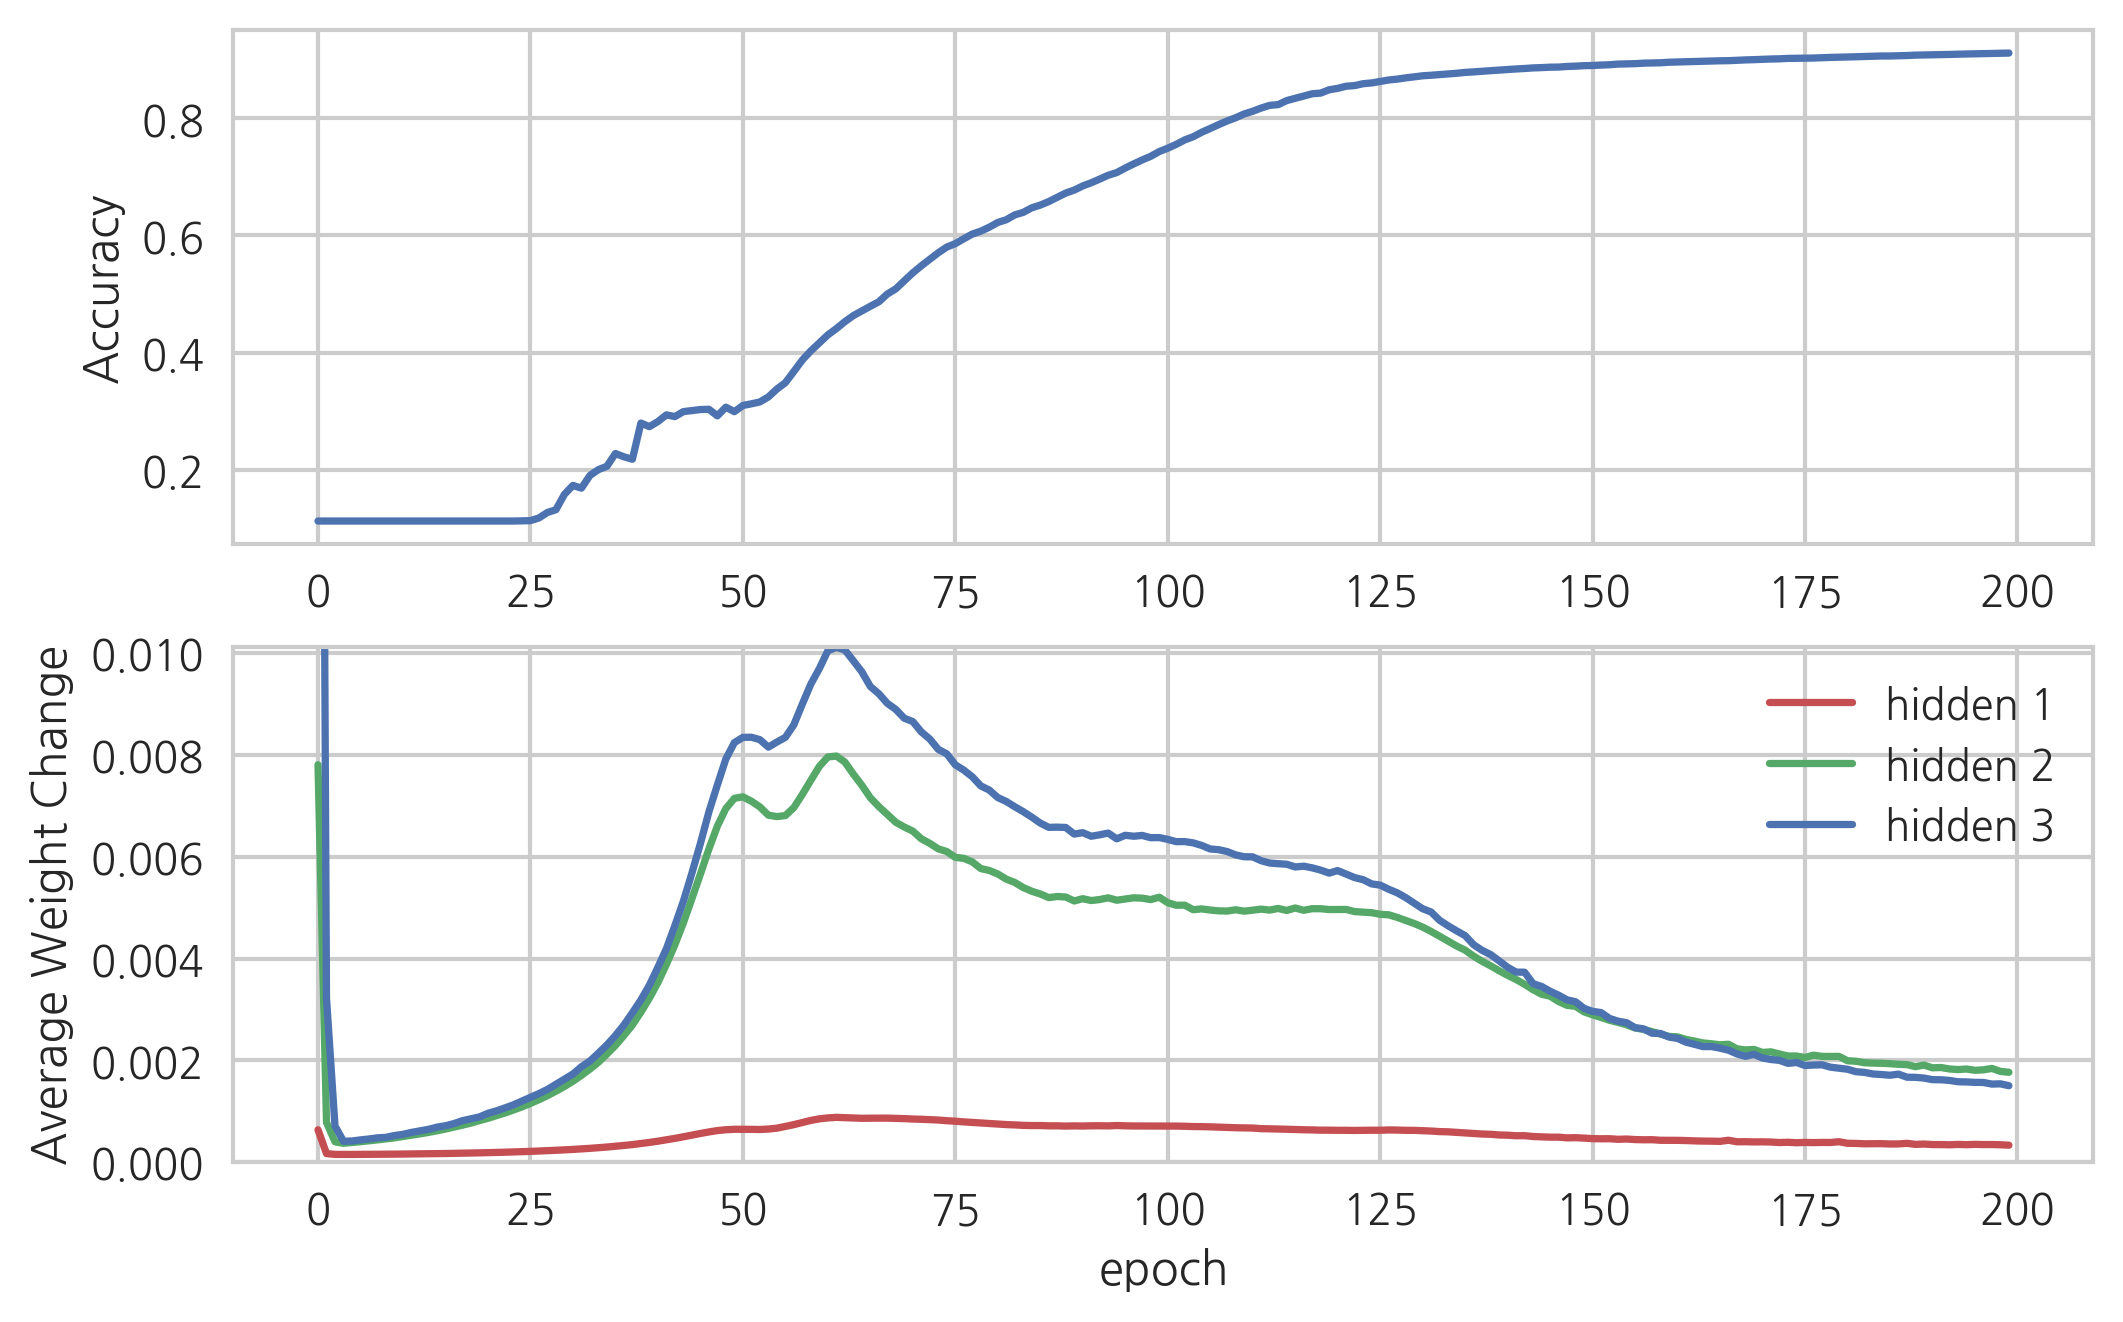

In [11]:
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(hist3.history['acc'])
plt.ylabel("Accuracy")
plt.subplot(2, 1, 2)
plt.plot(callback3.weight_change[0], 'r', label="hidden 1")
plt.plot(callback3.weight_change[1], 'g', label="hidden 2")
plt.plot(callback3.weight_change[2], 'b', label="hidden 3")
plt.xlabel("epoch")
plt.ylabel("Average Weight Change")
plt.ylim(0, np.max(callback3.weight_change[-1][5:]))
plt.legend()
plt.show()

In [12]:
hist3.history['acc'][-1]

0.9113833352923393

In [13]:
%%time
num_epoch = 200
callback4 = WeightHistory(model4, num_epoch)
hist4 = model4.fit(X_train, Y_train, epochs=num_epoch, batch_size=100, 
                   callbacks=[callback4], verbose=0)

CPU times: user 10min 2s, sys: 36.2 s, total: 10min 38s
Wall time: 4min 35s


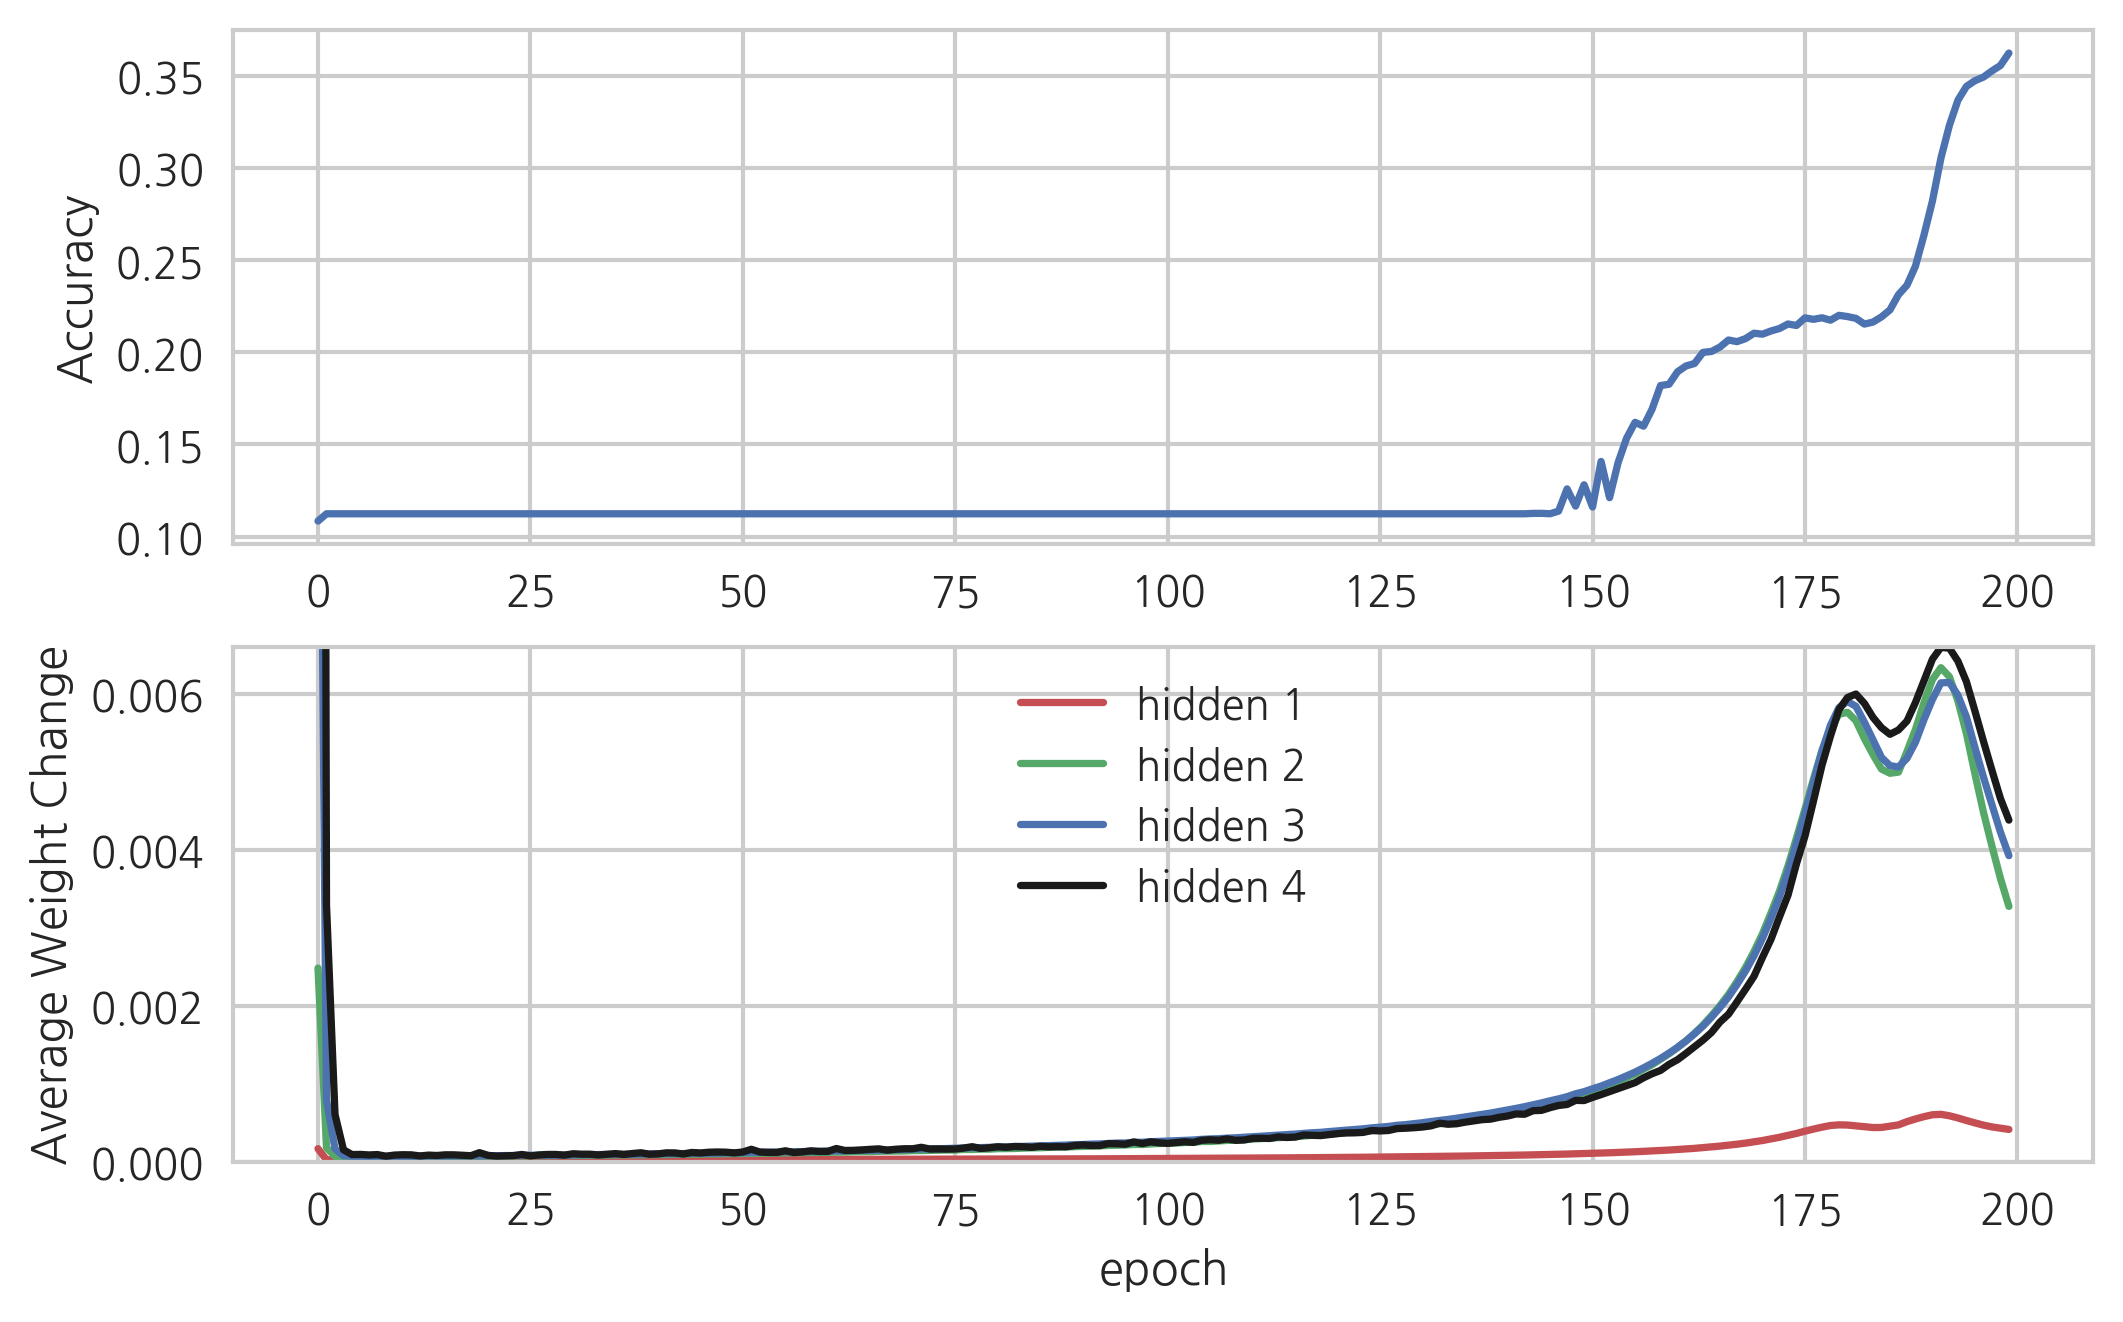

In [14]:
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(hist4.history['acc'])
plt.ylabel("Accuracy")
plt.subplot(2, 1, 2)
plt.plot(callback4.weight_change[0], 'r', label="hidden 1")
plt.plot(callback4.weight_change[1], 'g', label="hidden 2")
plt.plot(callback4.weight_change[2], 'b', label="hidden 3")
plt.plot(callback4.weight_change[3], 'k', label="hidden 4")
plt.xlabel("epoch")
plt.ylabel("Average Weight Change")
plt.ylim(0, np.max(callback4.weight_change[-1][5:]))
plt.legend()
plt.show()

In [15]:
hist4.history['acc'][-1]

0.36240000103910763

## 기울기와 수렴 속도 문제

은닉계층의 수가 너무 증가하면 수렴 속도 및 성능이 급격히 저하된다. 가중치가 감소하는 원인은 오차역전파(backpropagation)시에 오차가 뉴런을 거치면서 활성화 함수의 기울기가 곱해지는데 이 값이 1보다 작아서 계속 크기가 감소하기 때문이다. 

* 시그모이드 활성화함수 사용의 경우 

$$ \sigma'(0) = 1/4 $$

일반적으로 사용하는 잔차 제곱합(sum of square) 형태의 오차 함수는 대부분의 경우에 기울기 값이 0 이므로 (near-zero gradient) 수렴이 느려지는 단점이 있다.

$$
\begin{eqnarray}
z = \sigma (wx+b)
\end{eqnarray}
$$

$$
\begin{eqnarray}
  C = \frac{(y-z)^2}{2},
\end{eqnarray}
$$


$$
\begin{eqnarray} 
  \frac{\partial C}{\partial w} & = & (z-y)\sigma'(a) x \\
  \frac{\partial C}{\partial b} & = & (z-y)\sigma'(a)
\end{eqnarray}
$$


* if $x=1$, $y=0$, 
$$
\begin{eqnarray} 
  \frac{\partial C}{\partial w} & = & a \sigma'(a) \\
  \frac{\partial C}{\partial b} & = & a \sigma'(z)
\end{eqnarray}
$$

* $\sigma'$는 대부분의 경우에 0이다.

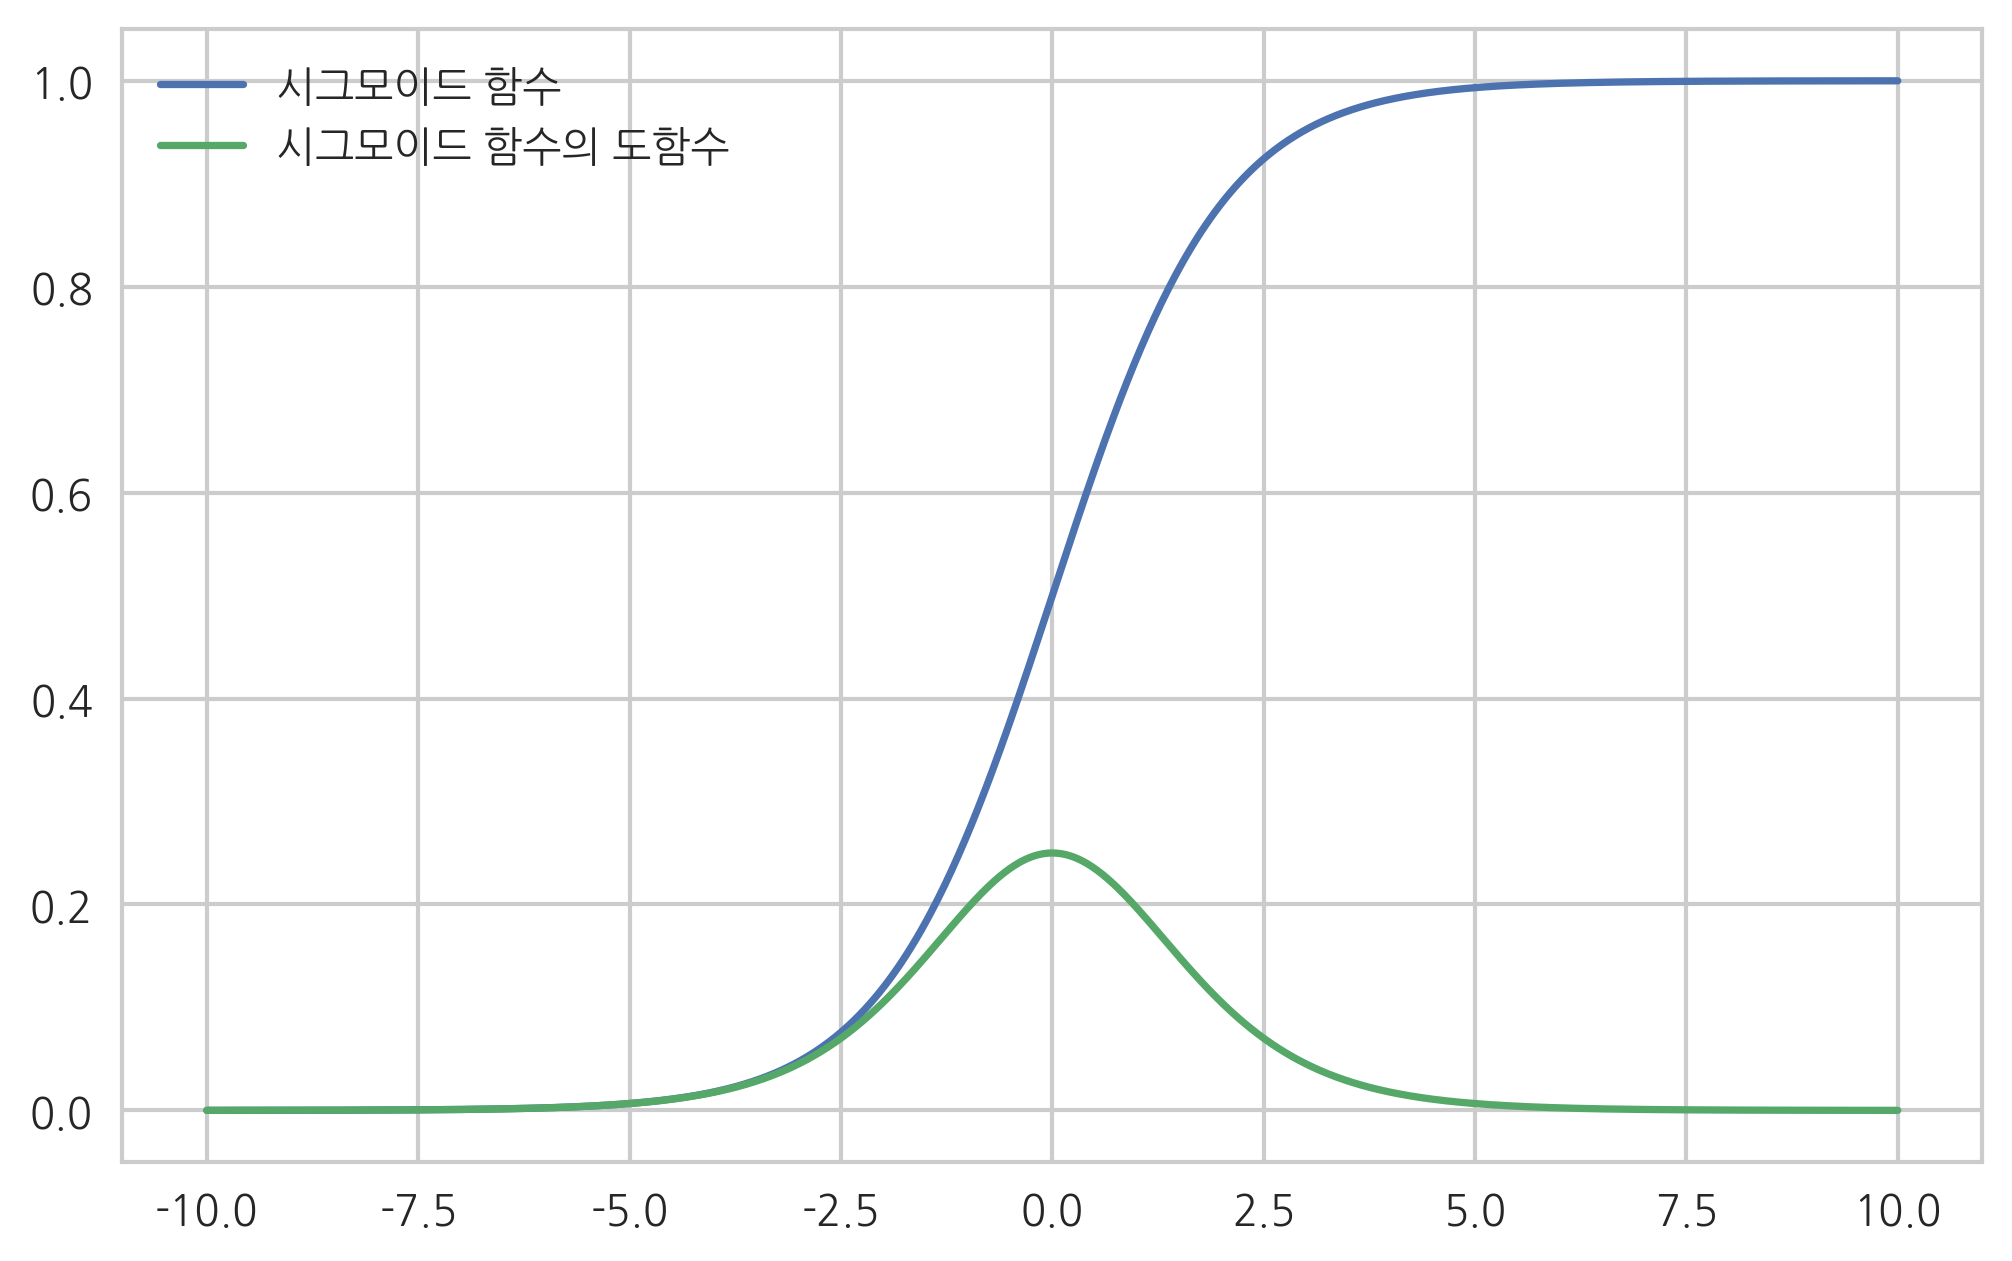

In [16]:
def sigmoid(x): 
    return 1/(1+np.exp(-x))


def sigmoid_prime(x): 
    return sigmoid(x)*(1-sigmoid(x))


xx = np.linspace(-10, 10, 1000)
plt.plot(xx, sigmoid(xx), label="시그모이드 함수")
plt.plot(xx, sigmoid_prime(xx), label="시그모이드 함수의 도함수")
plt.legend()
plt.show()